<a href="https://colab.research.google.com/github/YummyPancake/Unet_image_denoising/blob/master/fp_Unet_physical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import os
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils import data
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# resource: https://github.com/clvcooke/recurrent-illuminated-attention/blob/master/data_loader.py
datapath_train_images = r'C:/Users/panyu/OneDrive/Desktop/Duke learning/2nd year/ML in Image/final_project/malaria_norm.npy'
datapath_train_labels = r'C:/Users/panyu/OneDrive/Desktop/Duke learning/2nd year/ML in Image/final_project/malaria_labels.npy'

In [0]:
batch_size = 64
image_origin_shape=torch.from_numpy(np.load(datapath_train_images))
print(image_origin_shape.shape)
images = torch.from_numpy(np.load(datapath_train_images)).reshape((-1, 28, 28, 96)).float() / 255
images = torch.cat([images[:,:,:,1:10], images[:,:,:,11:19],images[:,:,:,20:32], images[:,:,:,33:42], images[:,:,:,43:51], images[:,:,:,52:64], images[:,:,:,65:74], images[:,:,:,75:83], images[:,:,:,84:]], axis=-1)
images = torch.tensor(images[:,:,:,29:29*2]) # select green channel
# print(images.dtype)
# print(images)
labels = torch.from_numpy(np.load(datapath_train_labels)).float()
dataset_train = data.TensorDataset(images[:922,:,:,:], labels[:922])# make dataset
dataset_test = data.TensorDataset(images[922:,:,:,:], labels[922:])
# dataset_train = data.TensorDataset(images,labels)


train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle = False)

# for i, (image, label) in enumerate(train_loader):
#   print(image.shape)

torch.Size([1021, 28, 28, 96])


C:\Users\panyu\Anaconda3\envs\myproject\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


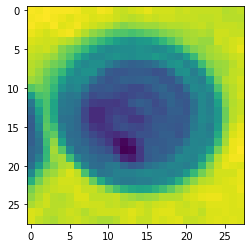

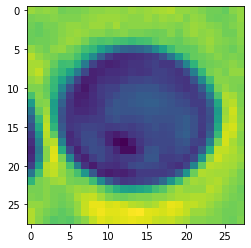

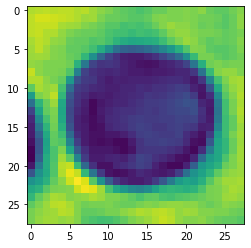

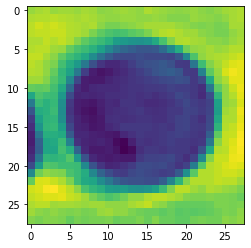

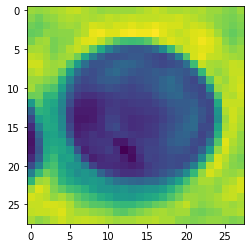

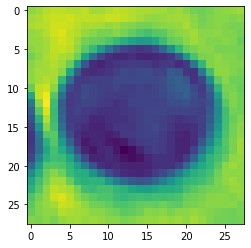

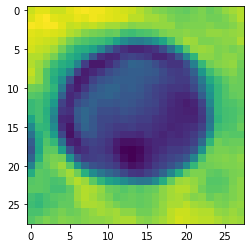

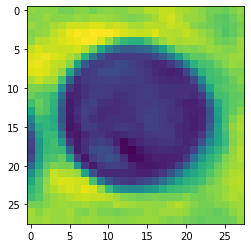

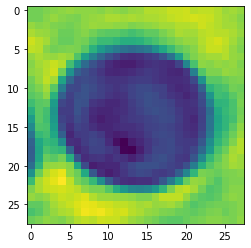

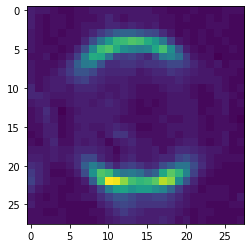

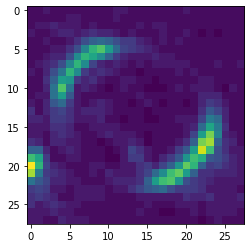

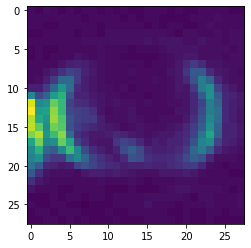

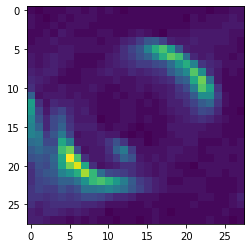

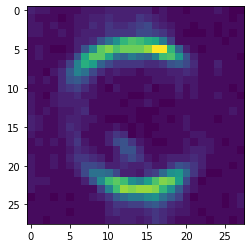

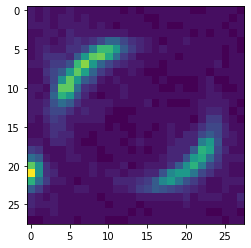

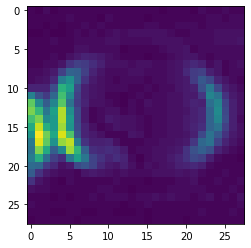

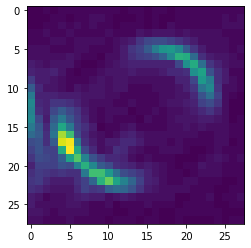

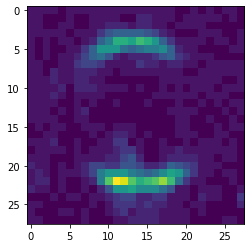

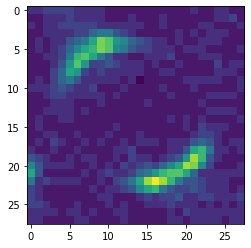

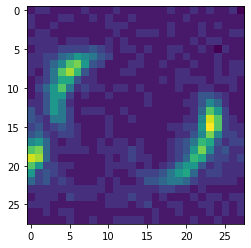

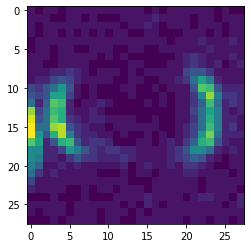

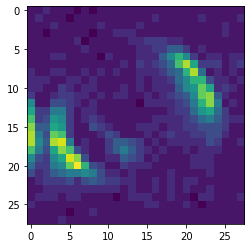

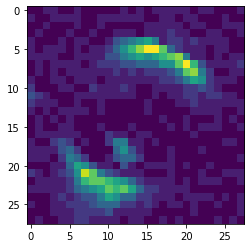

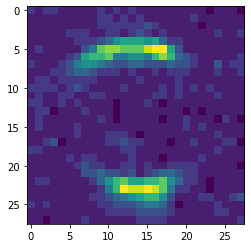

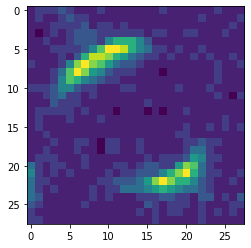

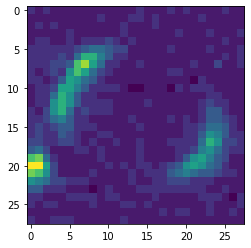

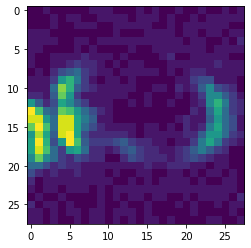

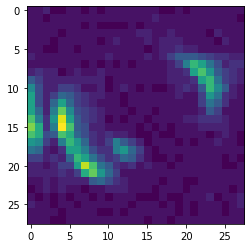

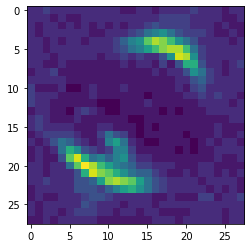

In [0]:
# label 0: normal cell, label 1: infected cell
for i in range(29): # sample images in each channel
    plt.figure()
    plt.imshow(images[1000,:,:,i])

In [0]:
original_im = torch.zeros((28,28))
for i in range(29):
  original_im += images[1000, :, :, i]

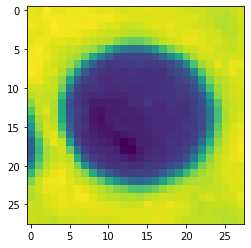

In [0]:
plt.imshow(original_im) # add up (green) 29 channels as the original image (truth)

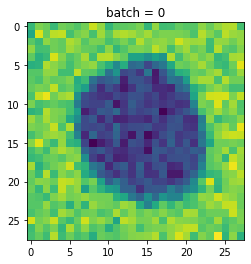

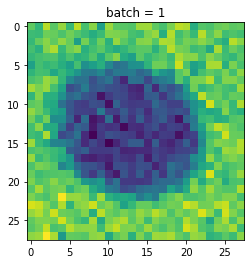

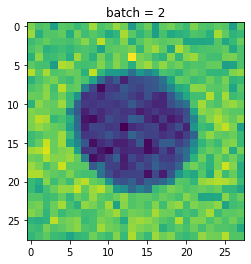

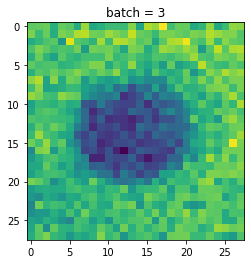

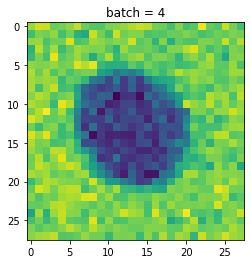

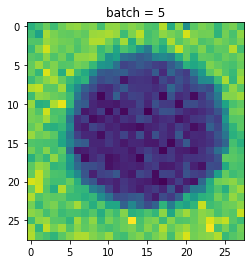

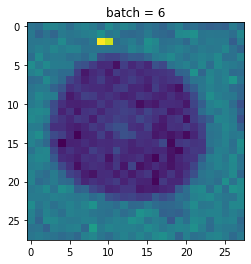

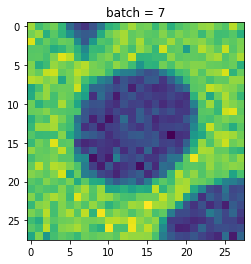

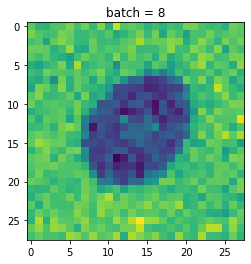

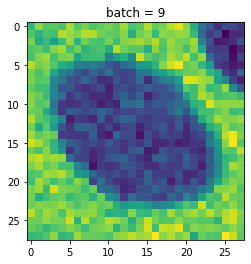

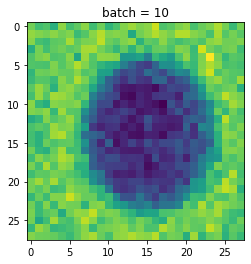

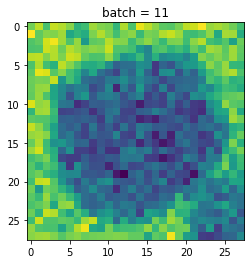

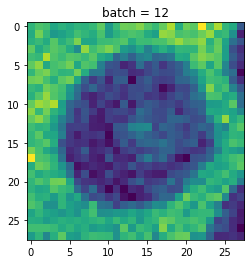

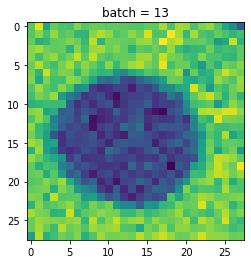

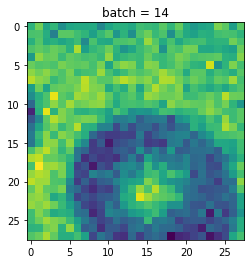

In [0]:
# generate noisy images (image in each channel has random gaussian noise in the same distribution)
for i,(images, labels) in enumerate(train_loader):
  mean = 0
  stddev = 0.05
  noise = np.random.normal(loc=mean, scale=stddev, size=np.shape(images))
  noise = torch.from_numpy(noise)
  noisy_image = images + noise
  sum_noisyim = torch.zeros((28,28))
  for j in range(29):
    sum_noisyim += noisy_image[i, :, :, j]
  plt.imshow(sum_noisyim)
  plt.title('batch = {}'.format(i))
  plt.show()

In [0]:
def sumImage_channels(image):
  sumIm = torch.zeros((image.shape[0],image.shape[2],image.shape[3]))
  for i in range(image.shape[1]):
    sumIm += image[:,i,:,:]
  return sumIm

In [0]:
def randomNoise(shape, stddev = 0.05):
    type = np.random.randint(0,1)
    if type == 0:
        noise = np.random.normal(loc = 0, scale = stddev, size = shape)
    else:
        noise = np.random.poisson(size = shape)
    noise = torch.from_numpy(noise)
    return noise

In [0]:
class UNet(nn.Module):
    def __init__(self, in_channels=29, out_channels=1):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        #physical layer
        self.phyconv = nn.Conv2d(in_channels=in_channels, out_channels=1, kernel_size=1, stride=1, padding=0) # same padding
        # Layers: enc_conv0, enc_conv1, pool1
        self._block1 = nn.Sequential(
            nn.Conv2d(1, 48, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2))
        # Layers: enc_conv(i), pool(i); i=2..5
        self._block2 = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2))
        # Layers: enc_conv6, upsample5
        self._block3 = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            #nn.ConvTranspose2d(48, 48, 3, stride=2, padding=1, output_padding=1))
            nn.Upsample(scale_factor=2, mode='nearest'))
        # Layers: dec_conv5a, dec_conv5b, upsample4
        self._block4 = nn.Sequential(
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            #nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
            nn.Upsample(scale_factor=2, mode='nearest'))
        # Layers: dec_deconv(i)a, dec_deconv(i)b, upsample(i-1); i=4..2
        self._block5 = nn.Sequential(
            nn.Conv2d(144, 96, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            #nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
            nn.Upsample(scale_factor=2, mode='nearest'))
        # Layers: dec_conv1a, dec_conv1b, dec_conv1c,
        self._block6 = nn.Sequential(
            nn.Conv2d(96 + 1, 64, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1, inplace=True),    
            nn.Conv2d(32, out_channels, 3, stride=1, padding=1))
        # Initialize weights
        self._init_weights()
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.zero_()
    def physicalLayer(self, X):
        noise = randomNoise(X.shape).float()
        y = X + noise
        return y
    def forward(self, x):
        # Encoder
        physical0 = self.phyconv(x)
        pool1 = self._block1(physical0)
        pool2 = self._block2(pool1)
        # pool3 = self._block2(pool2)
        # pool4 = self._block2(pool3)
        # pool5 = self._block2(pool4)
        # Decoder
        # upsample5 = self._block3(pool5)
        # concat5 = torch.cat((upsample5, pool4), dim=1)
        # upsample4 = self._block4(concat5)
        # concat4 = torch.cat((upsample4, pool3), dim=1)
        # upsample3 = self._block5(concat4)
        # concat3 = torch.cat((upsample3, pool2), dim=1)
        # upsample2 = self._block5(concat3)
        # concat2 = torch.cat((upsample2, pool1), dim=1)
        # upsample1 = self._block5(concat2)
        # concat1 = torch.cat((upsample1, x), dim=1)
        upsample2 = self._block3(pool2)
        concat2 = torch.cat((upsample2, pool1), dim=1)
        upsample1 = self._block4(concat2)
        concat1 = torch.cat((upsample1, physical0), dim=1)
        # print(concat1.shape)
        # Final activation
        return self._block6(concat1)

# initialize the NN
model = UNet().float()
print(model)
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

UNet(
  (phyconv): Conv2d(29, 1, kernel_size=(1, 1), stride=(1, 1))
  (_block1): Sequential(
    (0): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.1, inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_block2): Sequential(
    (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_block3): Sequential(
    (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Upsample(scale_factor=2.0, mode=nearest)
  )
  (_block4): Sequential(
    (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyRe

In [0]:
loss_list = []
n_epochs = 50
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.permute(0,3,1,2)
        real_img = torch.sum(images, dim = 1, keepdim = True) # truth image, one channel
        Physical_img = model.physicalLayer(images) # noisy image

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(Physical_img.float())      
        # print(outputs.dtype)
        # calculate the loss
        loss = criterion(output, real_img)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
              
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    loss_list.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))
    

Epoch: 1 	Training Loss: 179.552583
Epoch: 2 	Training Loss: 41.766667
Epoch: 3 	Training Loss: 25.397007
Epoch: 4 	Training Loss: 21.694273
Epoch: 5 	Training Loss: 20.489930
Epoch: 6 	Training Loss: 19.821636
Epoch: 7 	Training Loss: 17.240526
Epoch: 8 	Training Loss: 15.849606
Epoch: 9 	Training Loss: 16.878332
Epoch: 10 	Training Loss: 14.796731
Epoch: 11 	Training Loss: 12.898482
Epoch: 12 	Training Loss: 13.364734
Epoch: 13 	Training Loss: 11.488021
Epoch: 14 	Training Loss: 11.125302
Epoch: 15 	Training Loss: 11.409967
Epoch: 16 	Training Loss: 10.727934
Epoch: 17 	Training Loss: 9.928637
Epoch: 18 	Training Loss: 9.338655
Epoch: 19 	Training Loss: 9.564723
Epoch: 20 	Training Loss: 8.596532
Epoch: 21 	Training Loss: 8.226609
Epoch: 22 	Training Loss: 8.011639
Epoch: 23 	Training Loss: 7.546442
Epoch: 24 	Training Loss: 7.135225
Epoch: 25 	Training Loss: 7.010061
Epoch: 26 	Training Loss: 6.625751
Epoch: 27 	Training Loss: 6.358331
Epoch: 28 	Training Loss: 6.183364
Epoch: 29 	T

Text(0.5, 1.0, 'Training Loss (UNet with physical layer optimization)')

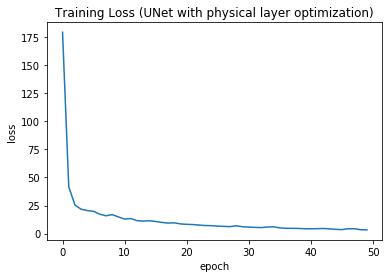

In [0]:
plt.figure()
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training Loss (UNet with physical layer optimization)')

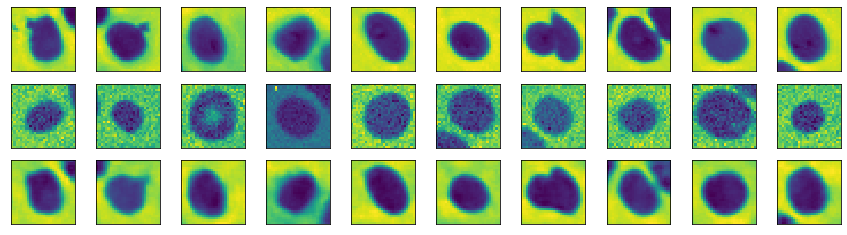

In [0]:
# real_img = real_img.detach().numpy()
# noisy_img = noisy_img.detach().numpy()
# output = output.detach().numpy()
test_images = real_img[0:10,:,:,:]
test_output = output[0:10,:,:,:]
test_noisy = noisy_img[0:10,:,:,:]
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(15,4))

# input images on top row, reconstructions on bottom
for images, row in zip([test_images, test_noisy, test_output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [0]:
test_loss = 0.0
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.permute(0,3,1,2)
        real_img = torch.sum(images, dim = 1, keepdim = True) # truth image, one channel
        Physical_img = model.physicalLayer(images) # noisy image
        output = model.forward(Physical_img.float())   
        loss = criterion(output, real_img)
        test_loss += loss.item()*images.size(0)
              
    # print avg training statistics 
    test_loss = test_loss/len(test_loader)
    print('Testing Loss: {:.6f}'.format(
      test_loss
      ))


Testing Loss: 5.631597


(1, 1, 28, 28)


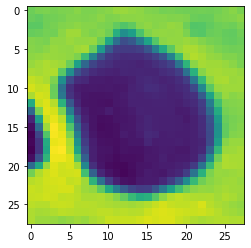

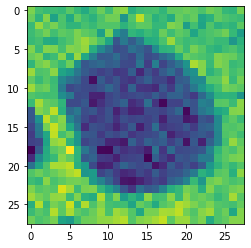

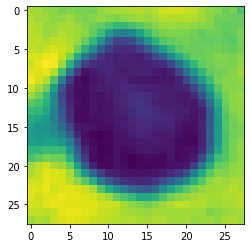

In [0]:
test_im = images[0:1,:,:,:]
test_phy = model.physicalLayer(test_im)
test_im_merge = torch.sum(test_im, dim = 1, keepdim = True)
test_im_merge = test_im_merge.detach().numpy()
print(test_im_merge.shape)
plt.imshow(test_im_merge[0,0,:,:])
plt.show()
test_phy_merge = torch.sum(test_phy, dim = 1, keepdim = True)
test_phy_image = test_phy_merge.detach().numpy()
plt.imshow(test_phy_merge[0,0,:,:])
plt.show()

denoised_im = model.forward(test_phy)
denoised_im = denoised_im.detach().numpy()
plt.imshow(denoised_im[0,0,:,:])
plt.show()


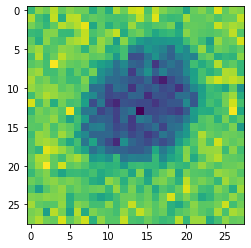

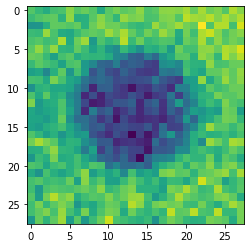

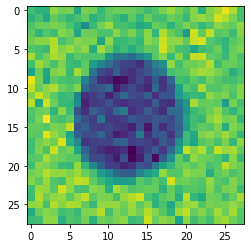

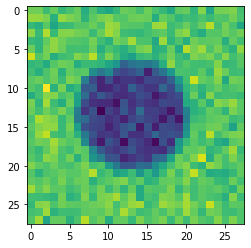

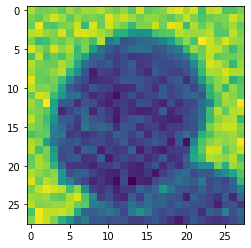

In [0]:
# outputs = outputs.detach().numpy()
# images = images.detach().numpy()
noisy_image = noisy_image.detach().numpy()
for im in range(5):
  # im_o = torch.zeros()
  sum_output = np.zeros((28,28))
  for c in range(29):
    sum_output += noisy_image[im, c, :, :]
  plt.imshow(sum_output)
  plt.show()

In [0]:
physical_trained_W = model.phyconv.weight
print(physical_trained_W.shape)
print(physical_trained_W[2,1,:,:])

torch.Size([29, 29, 1, 1])
tensor([[0.0885]], grad_fn=<SliceBackward>)
